In [1]:
import sys
import os

def get_FGCE_Directory():
    """Get the path of the 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness' directory."""
    current_dir = os.getcwd()
    while os.path.basename(current_dir) != 'FGCE-Feasible-Group-Counterfactual-Explanations-for-Auditing-Fairness':
        current_dir = os.path.dirname(current_dir)
        if current_dir == os.path.dirname(current_dir):
            return None
        
    return current_dir
FGCE_DIR = get_FGCE_Directory()
sys.path.append(FGCE_DIR)
def get_path_separator():
    """Get the system-specific directory separator."""
    return os.sep
sep = get_path_separator()
sys.path.append(FGCE_DIR + f'{sep}src')
sys.path.append(FGCE_DIR + f'{sep}baselines')

# Comparison with AReS approach 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import os
import tensorflow as tf
from ares import Apriori, TwoLevelRecourseSet, AReS
from dataset import dataset_loader
from FGCE import *
from kernel import *
from sklearn import preprocessing
import time
from tqdm import tqdm
import warnings
import os
import json
import math
import pickle as pk
warnings.filterwarnings("ignore")

In [3]:
def get_FGCE_Directory():
    """Get the path of the 'FGCE' directory."""
    current_dir = os.getcwd()
    while os.path.basename(current_dir) != 'FGCE':
        current_dir = os.path.dirname(current_dir)
        if current_dir == os.path.dirname(current_dir):
            return None
    return current_dir
FGCE_DIR = get_FGCE_Directory()

In [4]:
baseline = "AReS"
name = 'compas'
group_identifier = "sex"
classifier = "lr"
dataset = dataset_loader(name, dropped_features=[], n_bins=None)

X = dataset.data.iloc[:, :-1]
y = dataset.data.iloc[:, -1] 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=482, shuffle=True)

print(f"Number of samples in x_test: {len(x_test)}")
print(f"Number of samples in y_test: {len(y_test)}")

if classifier == "lr":
    clf = LogisticRegression(random_state=482)
    clf.fit(x_train, list(y_train))
    print(f"Training accuracy: {clf.score(x_train, list(y_train))}")
    print(f"Testing accuracy: {clf.score(x_test, list(y_test))}")

elif classifier == "xgb":
    clf = XGBClassifier(random_state=482)
    clf.fit(x_train, y_train)
    print("Training accuracy:", clf.score(x_train, y_train))
    print("Testing accuracy:", clf.score(x_test, y_test))
    
elif classifier == "dnn":
    clf = tf.keras.models.Sequential([
				tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
				tf.keras.layers.Dropout(0.5),
				tf.keras.layers.Dense(32, activation='relu'),
				tf.keras.layers.Dropout(0.5),
				tf.keras.layers.Dense(1, activation='sigmoid') 
			])

    clf.compile(optimizer='adam',
                loss='binary_crossentropy',  
                metrics=['accuracy'])
    
    clf.fit(x_train, y_train, epochs=10, batch_size=16, validation_split=0.1)  
    print("Training accuracy:", clf.evaluate(x_train, y_train)[1])
    print("Testing accuracy:", clf.evaluate(x_test, y_test)[1])
X

Number of samples in x_test: 1851
Number of samples in y_test: 1851
Training accuracy: 0.6844300278035218
Testing accuracy: 0.6628849270664505


,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,sex = Female,sex = Male,race = African-American,race = Asian,race = Caucasian,race = Hispanic,race = Native American,race = Other
0,69,0,0,0,0,0,0,1,0,0,0,0,0,1
1,34,0,0,0,0,0,0,1,1,0,0,0,0,0
2,24,0,0,1,4,0,0,1,1,0,0,0,0,0
3,44,0,0,0,0,1,0,1,0,0,0,0,0,1
4,41,0,0,0,14,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6162,23,0,0,0,0,0,0,1,1,0,0,0,0,0
6163,23,0,0,0,0,0,0,1,1,0,0,0,0,0
6164,57,0,0,0,0,0,0,1,0,0,0,0,0,1
6165,33,0,0,0,3,1,1,0,1,0,0,0,0,0


In [5]:
def get_FN_Negatives_Positives(x_test, y_test, clf, tp):
    """
    This function will return the False Negatives and all the negatively classified data points

    Parameters:
    -----------
    x_test: pandas DataFrame
        Test features
    y_test: pandas Series
        Test target variable
    clf: classifier
        Trained classifier model
    tp: float
        Threshold probability for classifying as positive

    Returns:
    --------
    positives_df: pandas DataFrame
        DataFrame containing positively classified data points
    negatives_df: pandas DataFrame
        DataFrame containing negatively classified data points that are false negatives
    """

    positives = []  
    negatives = []  

 
    data = pd.concat([x_test, y_test], axis=1)

    FEATURE_COLUMNS = x_test.columns
    TARGET_COLUMN = y_test.name

    positive_points = {}  
    negative_points = {}  
    FN = {}  

    for x_id, x in data.iterrows():
        if classifier == "lr":
            if clf.predict_log_proba([x[FEATURE_COLUMNS]])[0][1] > np.log(tp):
                positive_points[x_id] = x
            elif clf.predict([x[FEATURE_COLUMNS]]) == 0:
                negative_points[x_id] = x
                if x[TARGET_COLUMN] == 1:
                    FN[x_id] = x
        elif classifier == "xgb":
            if clf.predict_proba([x[FEATURE_COLUMNS]])[0][1] > tp:
                positive_points[x_id] = x
            elif clf.predict([x[FEATURE_COLUMNS]]) == 0:
                negative_points[x_id] = x
                if x[TARGET_COLUMN] == 1:
                    FN[x_id] = x
        elif classifier == "dnn":
            x_features = x[[col for col in FEATURE_COLUMNS]].values.reshape(1, -1)
            prediction_probabilities = clf.predict(x_features)
            predicted_class = (prediction_probabilities > tp).astype(int)
            predicted_class = predicted_class[0, 0]
            if predicted_class == 1:
                positive_points[x_id] = x
            else:
                negative_points[x_id] = x
                if x[TARGET_COLUMN] == 1:
                    FN[x_id] = x

    positives_df = pd.DataFrame.from_dict(positive_points, orient='index')
    negatives_df = pd.DataFrame.from_dict(negative_points, orient='index')
    FN_df = pd.DataFrame.from_dict(FN, orient='index')

    return FN_df, negatives_df, positives_df, positive_points
FN, negatives_df, positives_df, positive_points = get_FN_Negatives_Positives(x_test, y_test, clf, 0.6)

In [6]:
female_count = (FN['sex = Female'] == 1).sum()
male_count = (FN['sex = Male'] == 1).sum()
female_count,male_count,len(positive_points)

(20, 208, 750)

Generate AReS counterfactuals for female group

Dropping Feature: race
(228, 14)
Computing Candidate Sets of Conjunctions of Predicates SD and RL
------ 1851
Processing 612 combinations | Sampling itemset size 65
SD and RL Computed with Lengths 1 and 520
Saving Copies of SD and RL as SD_copy and RL_copy
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 520 to 515
Ground Set Computed with Length 1194
------------------------------------ 1194


1193it [00:03, 349.04it/s]


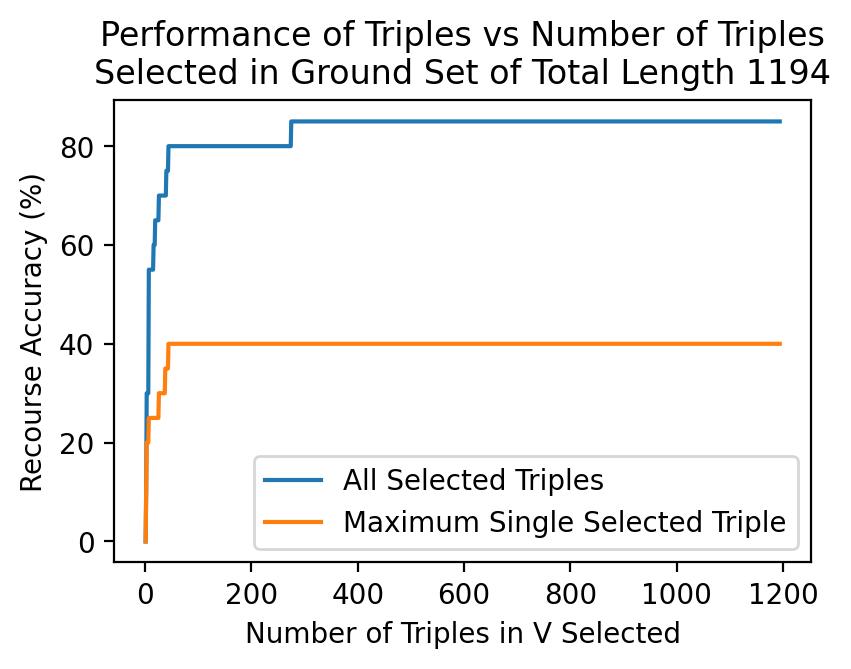

Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 1193/1193 [00:00<00:00, 8902.11it/s]


Checking Exchange


100%|██████████| 1191/1191 [00:00<00:00, 2795.69it/s]


Checking Delete
Checking Add


100%|██████████| 1191/1191 [00:00<00:00, 9160.81it/s]


------------------------------------ 3


2it [00:00, 153.67it/s]


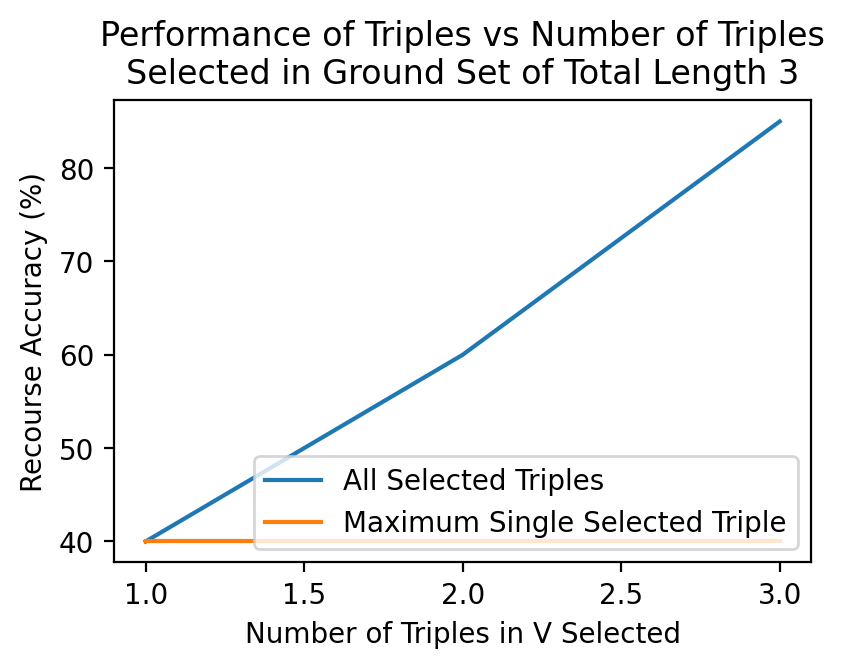

Coverage for female group = 0.85
Number of different selected rules used: 3


In [7]:
group = "sex = Female"

ares = AReS(model=clf, dataset=dataset, X=x_test, y=y_test, dropped_features=["race"], 
    n_bins=10, ordinal_features=[], normalise=None,
    constraints=[20,7,10])  
ares.generate_itemsets(apriori_threshold=None, max_width=None, 
                    affected_subgroup=group, save_copy=True)
ares.generate_groundset(max_width=None, RL_reduction=True,
                        then_generation=None, save_copy=False)
lams = [1, 0]
ares.evaluate_groundset(lams=lams, r=None, save_mode=1,
                        disable_tqdm=False, plot_accuracy=True)

ares.optimise_groundset(lams=lams, factor=1, print_updates=False, print_terms=False)

index_list = ares.X_aff.index.tolist()
mapping_indexes = {}
for idx, point in enumerate(index_list):
    mapping_indexes[idx] = point

total_indices_with_correctness = set()
num_of_rules = ares.R.correct_matrix.shape[0]

for i in range(num_of_rules):
    indices_with_correctness = np.where(ares.R.correct_matrix[i] == 100)[0]
    total_indices_with_correctness.update(indices_with_correctness)
    cost_per_point = ares.R.cost_matrix[i]
    
path = f"{FGCE_DIR}{sep}ares_cfes{sep}{name}{sep}{group}_algorithm_{classifier}.json"

ares.R.cfx_matrix
cfes_per_point = {}
counter=0
selected_rules = set()
for point in total_indices_with_correctness:
    min_cost = math.inf
    selected_rule = -1
    for rule in range(num_of_rules):
       point_cost = ares.R.cost_matrix[rule][point]
       if point_cost < min_cost:
            min_cost = point_cost
            selected_rule = rule
    selected_rules.add(selected_rule)
    point_cfe = ares.R.cfx_matrix[selected_rule][point]
    point_cfe_lst = list(point_cfe)
    counter += 1
    cfes_per_point[mapping_indexes[point]] = point_cfe_lst
    
if not os.path.exists(f"{FGCE_DIR}{sep}ares_cfes{sep}{name}{sep}"):  
    os.makedirs(f"{FGCE_DIR}{sep}ares_cfes{sep}{name}{sep}")

with open(path, 'w') as file:
    json.dump(cfes_per_point, file)
print(f"Coverage for female group = {counter/female_count}")
num_of_selected_rules = len(selected_rules)
print(f"Number of different selected rules used: {num_of_selected_rules}")

Generate AReS counterfactuals for male group 

Dropping Feature: race
(228, 14)
Computing Candidate Sets of Conjunctions of Predicates SD and RL
------ 1851
Processing 612 combinations | Sampling itemset size 65
SD and RL Computed with Lengths 1 and 520
Saving Copies of SD and RL as SD_copy and RL_copy
Computing Ground Set of Triples V
Ground Set Computed with Length 1194
------------------------------------ 1194


1193it [00:04, 239.17it/s]


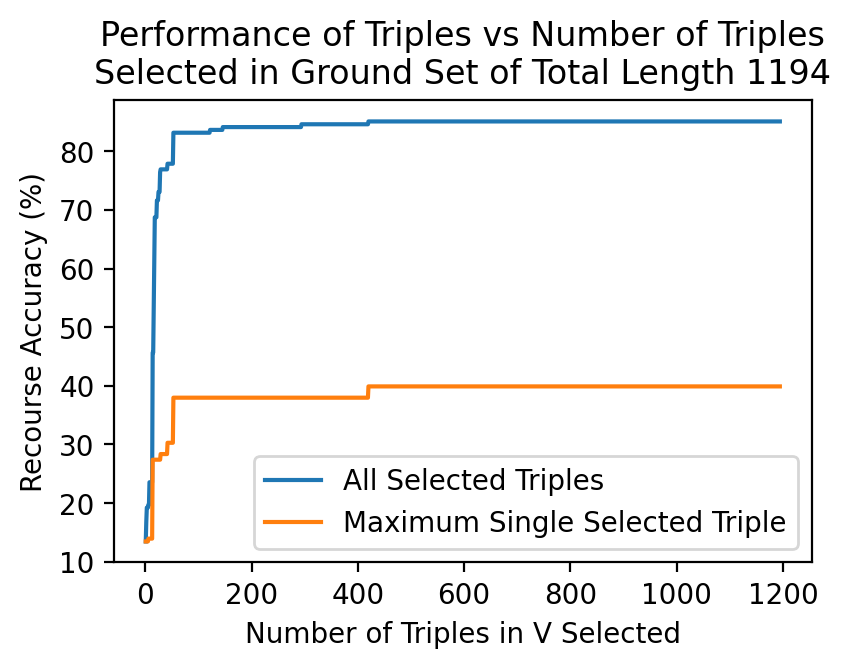

Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 1193/1193 [00:00<00:00, 8226.83it/s]


Checking Exchange


100%|██████████| 1187/1187 [00:00<00:00, 1203.87it/s]


Checking Delete
Checking Add


100%|██████████| 1187/1187 [00:00<00:00, 7967.12it/s]


------------------------------------ 7


6it [00:00, 162.18it/s]


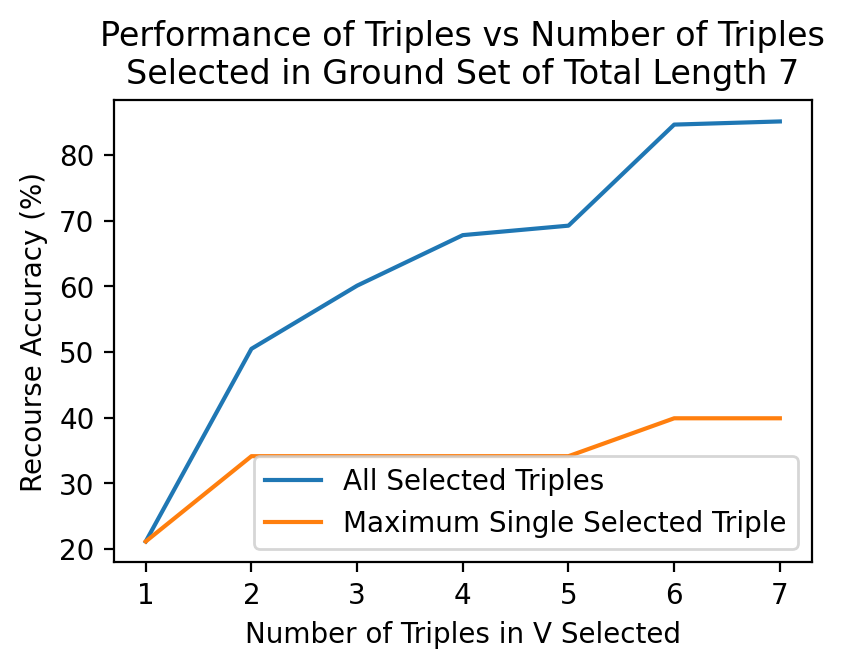

Coverage for male group = 0.8509615384615384
7
Number of different selected rules used: 5


In [8]:
group = "sex = Male"

ares = AReS(model=clf, dataset=dataset, X=x_test, y=y_test, dropped_features=["race"],
    n_bins=10, ordinal_features=[], normalise=None,
    constraints=[20,7,10])  
ares.generate_itemsets(apriori_threshold=None, max_width=None, 
                    affected_subgroup=group, save_copy=True)
ares.generate_groundset(max_width=None, RL_reduction=False,
                        then_generation=None, save_copy=False)
lams = [1, 0]
ares.evaluate_groundset(lams=lams, r=None, save_mode=1,
                        disable_tqdm=False, plot_accuracy=True)
ares.optimise_groundset(lams=lams, factor=1, print_updates=False, print_terms=False)

index_list = ares.X_aff.index.tolist()
mapping_indexes = {}
for idx, point in enumerate(index_list):
    mapping_indexes[idx] = point

total_indices_with_correctness = set()
num_of_rules = ares.R.correct_matrix.shape[0]
for i in range(num_of_rules):
    indices_with_correctness = np.where(ares.R.correct_matrix[i] == 100)[0]
    total_indices_with_correctness.update(indices_with_correctness)
    cost_per_point = ares.R.cost_matrix[i]
    
path = f"{FGCE_DIR}{sep}ares_cfes{sep}{name}{sep}{group}_algorithm_{classifier}.json"

ares.R.cfx_matrix
cfes_per_point = {}
counter1=0
selected_rules = set()
for point in total_indices_with_correctness:
    min_cost = math.inf
    selected_rule = -1
    for rule in range(num_of_rules):
       point_cost = ares.R.cost_matrix[rule][point]
       if point_cost < min_cost:
            min_cost = point_cost
            selected_rule = rule
    selected_rules.add(selected_rule)
    point_cfe = ares.R.cfx_matrix[selected_rule][point]
    point_cfe_lst = list(point_cfe)
    counter1+=1
    cfes_per_point[mapping_indexes[point]] = point_cfe_lst
    
if not os.path.exists(f"{FGCE_DIR}{sep}ares_cfes{sep}{name}{sep}"):  
    os.makedirs(f"{FGCE_DIR}{sep}ares_cfes{sep}{name}{sep}")

with open(path, 'w') as file:
    json.dump(cfes_per_point, file)
print(f"Coverage for male group = {counter1/male_count}")
print(num_of_rules)
num_of_selected_rules = len(selected_rules)
print(f"Number of different selected rules used: {num_of_selected_rules}")

In [9]:
ares_cfes = {}
ares_cfes_path = f"{FGCE_DIR}{sep}ares_cfes{sep}{name}{sep}"
if os.path.exists(ares_cfes_path):
    for filename in os.listdir(ares_cfes_path):
        if filename.endswith('.json'):
            file_path = os.path.join(ares_cfes_path, filename)
            try:
                with open(file_path, 'r') as file:
                    cfes_per_group = json.load(file)
                    ares_cfes.update(cfes_per_group)		 
            except Exception as e:
                print(f"Error loading data from {filename}: {e}")

In [ ]:
ares_cfes_path

Add AReS cfes into our graph

In [10]:
class distance_obj:
	def __init__(self):
		return

	def computeDistance(self, xi, xj):
		dist = np.linalg.norm(xi - xj, 2)
		return dist

	def pairwise_distances(self, data):
		"""
		This function is used to calculate the pairwise distances between the data points

		# Parameters:
		data: DataFrame
			the data points

		# Returns:
		distances: numpy array
			pairwise distances between the data points
		"""

		n = len(data)
		distances = np.zeros((n, n))
		for i in tqdm(range(n), desc="Calculating pairwise distances"):
			data_i = data[i]
			for j in range(i + 1, n):
				dist = np.linalg.norm(data_i - data[j], 2)
				distances[i, j] = dist
				distances[j, i] = dist  

		return distances
	
def add_ares_cfes_into_data(data_np, data_df, ares_cfes):
    """
    Adds AReS cfes into existing data.   
    Parameters:
        data: Existing data.
        ares_cfes: AReS cfes.

    Returns:
        DataFrame: Merged DataFrame containing both existing data and AReS cfes.
        array: Merged array containing both existing data and AReS cfes.
        int: Index where the AReS cfes data starts in the merged array.
    """
    
    data_df = data_df.iloc[:, :-1]  
    ces_df = pd.DataFrame.from_dict(ares_cfes, orient='index')
    ces_df.reset_index(drop=True, inplace=True)
    print(f"Length of data before adding ares's cfes",len(data_df))
    ces_df = ces_df.rename(columns=dict(zip(ces_df.columns, list(data_df.columns))))
        
   
    data_with_ares_cfes_df = pd.concat([data_df, ces_df], axis=0)
    data_with_ares_cfes_df.reset_index(drop=True, inplace=True)

    ces_np = ces_df.to_numpy()
    data_with_ares_ces_np = np.concatenate((data_np, ces_np))
    ces_start_index = len(data_np)
    print(f"Length of data after adding ares's cfes",len(data_with_ares_cfes_df))
	
    return data_with_ares_cfes_df, data_with_ares_ces_np, ces_start_index

In [32]:
def make_graph(X, distances, kernel, feasibility_constraints, epsilon, datasetName):
    """
    Create a graph using the adjacency list representation

    # Parameters:
    -----------
        - X: (pandas DataFrame)
            The data points
        - distances: (dict)
            The distances between the data points
        - kernel: (object)
            The kernel object
        - feasibility_constraints: object
            The feasibility constraints object
        - epsilon: (float)
            The epsilon value
        - datasetName: (str)
            The name of the dataset
    
    # Returns:
    --------
        - G: (nx.Graph)
            The graph
        - distances: (array)
            The distances between the data points
        - densities: (dict)
            The densities between the data points
    """
    N = X.shape[0]
    G = nx.DiGraph()
    edges = []
    densities = {} 

    for i in tqdm(range(0, N), desc="Building graph..."):
        G.add_node(i)
        xi = X[i]
        for j in range(i + 1, N):
            xj = X[j]
            dist = distances[i, j]
            if dist < epsilon:
                density = None
                wij = 0
                if feasibility_constraints.check_constraints(xi, xj):
                    density = kernel.kernelKDE(xi, xj, dist)
                    densities[(i, j)] = density
                    wij = dist * density
                    if isinstance(wij, np.ndarray) and wij.size == 1:
                        wij = wij.item()
                    edges.append((i, j, {'distance': dist, 'wij': wij}))
                    
                if feasibility_constraints.check_constraints(xj, xi):
                    if density is None:
                        density = kernel.kernelKDE(xi, xj, dist)
                        wij = dist * density
                    densities[(i, j)] = density
                    if isinstance(wij, np.ndarray) and wij.size == 1:
                        wij = wij.item()
                    edges.append((j, i, {'distance': dist, 'wij': wij}))

    
    G.add_edges_from(edges)
    return G, distances, densities

In [34]:
epsilon = 0.3
skip_distance_calculation = True
skip_graph_creation = True

baseline = "AReS"

data_np = dataset.data.to_numpy()

attr_col_mapping = {col: i for i, col in enumerate(dataset.data.columns)}
FEATURE_COLUMNS = dataset.data.columns[:-1]
TARGET_COLUMNS = dataset.data.columns[-1]
X = data_np[:, [attr_col_mapping[col] for col in FEATURE_COLUMNS]]

X_copy = X.copy()
data_copy = dataset.data.copy()
data_with_ares_ces_df, data_with_ares_cfes_np, ces_start_index = add_ares_cfes_into_data(X_copy, data_copy, ares_cfes)


min_max_scaler_1 = preprocessing.MinMaxScaler()
data_with_ares_cfes_scaled = min_max_scaler_1.fit_transform(data_with_ares_cfes_np)

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

dataset_name = "Compas"

kernel = Kernel_obj(dataset_name, X, skip_bandwith_calculation=False, bandwith_approch="mean_scotts_rule")
kernel.fitKernel(X_scaled)

dist_obj = distance_obj()

fgce = FGCE(data_np, X, kernel, FEATURE_COLUMNS, TARGET_COLUMNS, epsilon, clf)

feasibility_constraints = utils.getFeasibilityConstraints(FEATURE_COLUMNS, dataset_name=dataset_name)

distances = []
densities = []

if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}"):
	os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}")

if skip_distance_calculation and "Distances"+baseline+".pkl" in os.listdir(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}"):
    print("Loading distances from file ...")
    distances = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}"+dataset_name+f"{sep}Distances"+baseline+".pkl", "rb"))
else:
    start_time = time.time()
    distances = dist_obj.pairwise_distances(data_with_ares_cfes_scaled)
    end_time = time.time()
    execution_time = end_time - start_time
    print("Calculating pairwise distances - Time:", execution_time, "seconds")
    pk.dump(distances, open(f"{FGCE_DIR}{sep}tmp{sep}"+dataset_name+f"{sep}Distances"+baseline+".pkl", "wb"))

print(f"Max distance in the dataset: {np.sqrt(len(FEATURE_COLUMNS))}")
print(f"Max possible distance considered in graph: {np.max(distances)}")

if skip_graph_creation and os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}Graph_{epsilon}_{baseline}.pkl"):
	
		print("Loading graph from file ...")
		graph = pk.load(open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}Graph_{epsilon}_{baseline}.pkl", "rb"))
		print(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}Graph_{epsilon}_{baseline}.pkl")
		fgce.set_graph(graph)

		print("Loading densities from file ...")
else:
	if not os.path.exists(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}"):
		os.makedirs(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}")
	 
	graph, distances, densities = make_graph(data_with_ares_cfes_scaled, distances, kernel, feasibility_constraints, epsilon, dataset_name)
	
	pk.dump(graph, open(f"{FGCE_DIR}{sep}tmp{sep}{dataset_name}{sep}Graphs{sep}Graph_{epsilon}_{baseline}.pkl", "wb"))

fully_connected_nodes = len(data_with_ares_ces_df)
connected_nodes = len(graph)
node_connectivity = connected_nodes / fully_connected_nodes * 100
print(f"{connected_nodes} nodes are connected out of {fully_connected_nodes} nodes. Connectivity: {node_connectivity}%")

fully_connected_edges = (fully_connected_nodes * (fully_connected_nodes - 1)) / 2
connected_edges = len(graph.edges())
edge_connectivity = connected_edges / fully_connected_edges * 100
print(f"{connected_edges} edges are connected out of {fully_connected_edges} edges. Connectivity: {edge_connectivity}%")

Length of data before adding ares's cfes 6167
Length of data after adding ares's cfes 6361
Calculating bandwidth for Compas...
Bandwidth: 1.7469280516706223
Fitting kernel...
Loading distances from file ...
Max distance in the dataset: 3.7416573867739413
Max possible distance considered in graph: 2.6064408011428584


Building graph...: 100%|██████████| 6361/6361 [15:53<00:00,  6.67it/s] 


6361 nodes are connected out of 6361 nodes. Connectivity: 100.0%
1084946 edges are connected out of 20227980.0 edges. Connectivity: 5.36359043265813%


In [36]:
path_num = 0
total_distances = 0
ces_id = ces_start_index
nodes = list(graph.nodes())
for FN_id, cfe in ares_cfes.items(): 
    if int(FN_id) in nodes and ces_id in nodes:
        if nx.has_path(graph, int(FN_id), ces_id):
            path_cost_wij, path = nx.single_source_dijkstra(graph, int(FN_id), target=ces_id, weight='wij') 
            distance = distances[int(FN_id)][ces_id]
            total_distances += distance
            path_num += 1

    ces_id += 1


average_distance_cost = total_distances / path_num if path_num != 0 else 0

percentage_of_paths_found = (path_num / len(FN)) 

print(f"Number of paths found = {percentage_of_paths_found}")
print(f"Average distance cost by AReS = {average_distance_cost}")

Number of paths found = 0.7280701754385965
Average distance cost by AReS = 0.24684283693478382
